In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv("data.csv", encoding='latin1')
data.head()

/tmp/ipython-input-4166017907.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding='latin1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [ ]:
x = data ['no2']
r = 102316088
a_r = 0.5 * ( r % 7)
b_r = 0.3 * ( r % 5 + 1)
z = x + a_r*np.sin(b_r*x)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [16]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=1e-3)
opt_D = optim.Adam(D.parameters(), lr=1e-3)

z_tensor = torch.tensor(z, dtype=torch.float32).view(-1, 1)
batch_size = 128
epochs = 3000
if torch.isnan(z_tensor).any():
    z_tensor_cleaned = z_tensor[~torch.isnan(z_tensor)].view(-1, 1)
else:
    z_tensor_cleaned = z_tensor

for epoch in range(epochs):
    if len(z_tensor_cleaned) < batch_size:
        print(f"Warning: Not enough clean data points for a batch. Skipping epoch {epoch}.")
        continue

In [17]:
idx = torch.randint(0, len(z_tensor_cleaned), (batch_size,))
real = z_tensor_cleaned[idx]
noise = torch.randn(batch_size, 1)
fake = G(noise)

D_real = D(real)
D_fake = D(fake.detach())

loss_D = (
    criterion(D_real, torch.ones_like(D_real)) +
    criterion(D_fake, torch.zeros_like(D_fake))
)

opt_D.zero_grad()
loss_D.backward()
opt_D.step()

D_fake = D(fake)
loss_G = criterion(D_fake, torch.ones_like(D_fake))

opt_G.zero_grad()
loss_G.backward()
opt_G.step()

with torch.no_grad():
    z_fake = G(torch.randn(10000, 1)).detach().cpu().numpy().flatten()


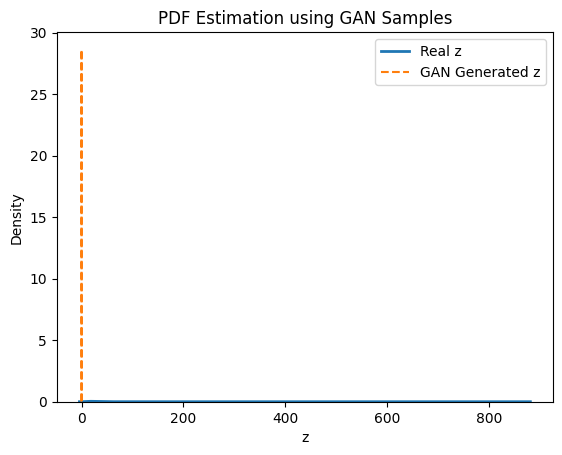

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(z, label="Real z", linewidth=2)
sns.kdeplot(z_fake, label="GAN Generated z", linestyle="--")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.title("PDF Estimation using GAN Samples")
plt.show()